# Project

**Data Preparation**

In [1]:
%%capture
!git clone --single-branch --branch v0.2dev https://github.com/scikit-learn-contrib/py-earth.git
%cd py-earth
!python setup.py install --cythonize

In [130]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
from pyearth import Earth

In [146]:
food_data = pd.read_csv('dec21pub.csv')

In [147]:
food_data.shape

(127489, 507)

"Measures that combine information from multiple items (HRFS12M1 and following) are generally considered to be more reliable measures of food security and food insecurity" <br>

Maybe we want to drop predictors, as they are manipulations of the existing variables. Or explore VIF

In [157]:
list(food_data.columns).index('HES1A')

391

In [158]:
list(food_data.columns).index('HRFS12M1')
#the 486th column of the data.

487

HRINTSTA informs whether or not the interview took place. We only want interviews that are complete!

In [159]:
#1's mean that the interview took place. Filter for this
#HRSUPINT 1's mean that the food security supplement survey took place. Filter for this too

food_data = food_data.loc[food_data['HRINTSTA']==1, :]
food_data = food_data.loc[food_data['HRSUPINT']==1,:]
food_data.shape

#these are households that completed the interview and the food security supplement survey. Ensuring no missing vals

(71533, 507)

In [160]:
#response variable: -5 indicates a missing val...
to_drop = list(food_data.loc[food_data['HRFS12CX']==-5, :].index) #38 vals were dropped here
food_data = food_data.drop(to_drop, axis=0)
food_data.shape

(71533, 507)

In [161]:
#changing 1 and 2 to 0 and 1...does this matter though?
food_data['y'] = food_data['HRFS12CX'].apply(lambda x: 0 if 1 == x 
                                              else 1)
response = pd.DataFrame(food_data.y.value_counts())
response

,y
0,59124
1,12409


Proportion of Food Insecure Houses: 0.17347238337550502
Proportion of Food Secure Houses: 0.826527616624495 




<Axes: ylabel='y'>

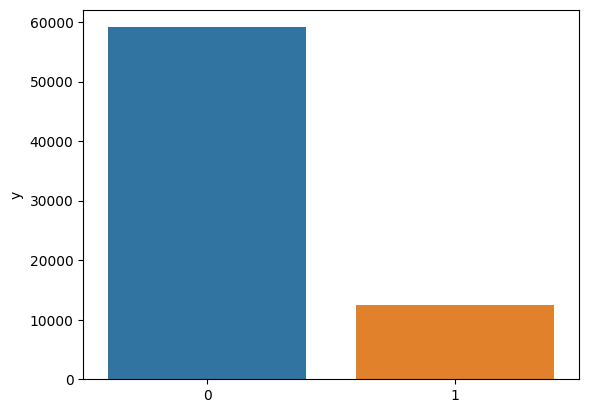

In [162]:
print('Proportion of Food Insecure Houses:', (response.loc[1, 'y']/response.y.sum()))
print('Proportion of Food Secure Houses:', (response.loc[0, 'y']/response.y.sum()), '\n\n')
sns.barplot(response, x = response.index, y = 'y')

In [166]:
#splitting the data
y = food_data.y
X = food_data.iloc[:, 0:391]
X = X.drop('FILLER', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 45)

In [142]:
print('Insecure:', y_train.sum()/len(y_train))
print('Secure:', (len(y_train) - y_train.sum())/len(y_train))

Insecure: 0.1726837451508056
Secure: 0.8273162548491945


In [143]:
print('Insecure:', y_test.sum()/len(y_test))
print('Secure:', (len(y_test) - y_test.sum())/len(y_test))

Insecure: 0.17662682602921648
Secure: 0.8233731739707836


In [36]:
train = pd.concat([X_train,y_train], axis=1)

# EDA

In [41]:
corr = food_data.iloc[:, 0:391].corrwith(food_data.y).sort_values(ascending = False)
corr[abs(corr)>0.1]

HETENURE    0.216970
PUDIS       0.111398
HRHTYPE     0.107549
HEHOUSUT    0.102784
PUIOCK1    -0.100104
PUHRCK6    -0.100410
PXHRAVL    -0.100635
PUHRCK5    -0.100999
PUHRCK2    -0.101102
PUHRCK3    -0.102738
PUHROT1    -0.103298
PUHRCK7    -0.104051
PEHRUSLT   -0.104335
PUHROFF1   -0.104630
PRHRUSL    -0.105502
PEHRUSL1   -0.106332
PREMPHRS   -0.107232
PEHRACTT   -0.107996
PEHRACT1   -0.110675
PEHSPNON   -0.124105
PESPOUSE   -0.127085
HEFAMINC   -0.382239
dtype: float64

In [42]:
corr[corr.isna()]

HRMONTH    NaN
HRYEAR4    NaN
FILLER     NaN
HUTYPEA    NaN
HUTYPC     NaN
HRINTSTA   NaN
HUBUSL4    NaN
PULKDK4    NaN
PULKDK5    NaN
PULKDK6    NaN
PULKPS3    NaN
PULKPS4    NaN
PULKPS5    NaN
PULKPS6    NaN
HXPHONEO   NaN
dtype: float64

**The highest correlated survey questions include:** <br>
Positively:<br>
- HES9: In the last 12 months, since
December of last year, did you ever run short
of money and try to make your food or your
food money go further? <br>
- HRPOOR:  Recoded from HEFAMINC (1: Below 185% poverty
2: Above 185% poverty or income not reported) <br>
- HEFAMINC: COMBINED INCOME OF ALL FAMILY MEMBERS
 DURING THE LAST 12 MONTHS[...] WHO ARE 15 YEARS OF AGE OR OLDER. (Higher Encoded: More Money) <br>
-HES8B: In order to buy just enough food to meet 1034 -1035
(your needs/the needs of your household),
would you need to spend more than you do
now, or could you spend less? (1: More, 2: Less)
- HETS8DO: Out variable that represents how much LESS 1039 -1041
could be spent each week and still buy just
enough food to meet household needs.
Created from HUS8D, HUS8DCKA, HUS8DCKB,
or HUS8DCOR. Top code 200

Negatively:<br>
- HESS1       0.712532 <br>
- HESH4       0.640454<br>
- HESH5       0.637635<br>
- HESH2       0.636681<br>
- HESH3       0.627601<br>

In [32]:
np.corrcoef(food_data.HRPOOR, food_data.y)

array([[1.        , 0.47499814],
       [0.47499814, 1.        ]])

<Axes: xlabel='HRPOOR', ylabel='y'>

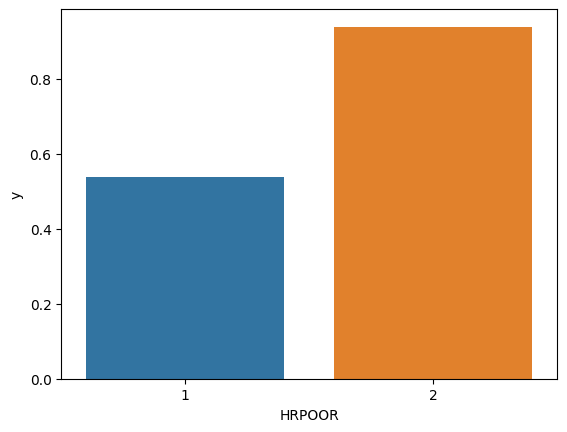

In [34]:
sns.barplot(data = food_data, x = food_data.HRPOOR, y = food_data.y, errorbar = None)

<AxesSubplot:>

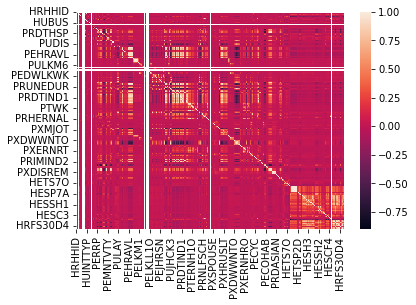

In [ ]:
sns.heatmap(food_data.corr())

# performing variable selection

basic random forest model

In [43]:
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier

model = RandomForestClassifier(n_jobs=-1).fit(X_train, y_train)

In [44]:
importances = np.mean([tree.feature_importances_ for tree in model.estimators_], axis=0)
importances = pd.DataFrame(importances)

In [45]:
df = pd.concat([pd.DataFrame(model.feature_names_in_, columns = ['Predictors']), importances], axis = 1)
df = df.rename(columns = {0: 'Importances'})
df = df[df.Importances > 0.000000000000]
df.set_index('Predictors').sort_values(by = 'Importances', ascending = False)

,Importances
Predictors,
HEFAMINC,8.729361e-02
QSTNUM,2.876774e-02
HRHHID,2.841662e-02
HWHHWGT,2.655451e-02
PWFMWGT,2.470734e-02
...,...
PEAFWHN4,2.219459e-06
PULKDK2,1.866884e-06
PTOT,1.014999e-06


In [46]:
print('Minimum Importance:',  df.Importances.min())
print('Maximum Importance:', df.Importances.max())

Minimum Importance: 8.711870964163109e-09
Maximum Importance: 0.08729360802874236


In [47]:
for importance in [10**-9, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2]:
  print(importance)

1e-09
1e-06
1e-05
0.0001
0.001
0.01


In [48]:
df[df.Importances > 0.001]

,Predictors,Importances
0,HRHHID,0.028417
3,HURESPLI,0.006569
4,HUFINAL,0.002814
5,HETENURE,0.018152
6,HEHOUSUT,0.005912
...,...,...
384,PECERT1,0.001528
385,PECERT2,0.001861
386,PECERT3,0.001428
387,PXCERT1,0.002607


In [49]:
train.loc[:, (df[df.Importances > 0.001]).Predictors.to_list() + ['y']]

,HRHHID,HURESPLI,HUFINAL,HETENURE,HEHOUSUT,HETELHHD,HETELAVL,HEPHONEO,HEFAMINC,HWHHWGT,...,PEDISOUT,PRDISFLG,HXFAMINC,PRDASIAN,PECERT1,PECERT2,PECERT3,PXCERT1,PXCERT2,y
112251,507340501120403,1,201,3,1,1,-1,1,13,34491316,...,2,2,42,-1,2,-1,-1,0,0,0
89743,578660581951003,1,201,3,5,1,-1,1,3,12853838,...,2,2,0,-1,2,-1,-1,0,0,0
114059,967582201340105,1,201,2,5,1,-1,1,10,37756466,...,2,2,23,-1,2,-1,-1,0,0,0
33973,410100031131678,1,201,2,1,1,-1,1,16,40579130,...,2,2,0,-1,2,-1,-1,20,0,0
20904,219010610013449,4,201,1,1,1,-1,1,16,45467838,...,2,2,0,-1,2,-1,-1,20,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18379,310946170108105,1,201,3,1,1,-1,1,13,21372705,...,-1,-1,0,-1,-1,-1,-1,-1,-1,0
94077,411809460586216,1,201,1,1,1,-1,1,11,33387906,...,2,2,0,-1,2,-1,-1,0,0,0
8856,40710040307671,1,1,2,1,1,-1,1,1,40151439,...,-1,-1,0,-1,-1,-1,-1,-1,-1,0
98134,28720188901004,1,201,1,1,1,-1,1,15,28083647,...,2,2,0,-1,1,2,2,0,0,0


In [50]:
from sklearn.model_selection import cross_val_score,train_test_split, cross_val_predict
importance_thresholds = [10**-9, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2]
accuracy_scores = []
for importance in importance_thresholds:
  threshold = df[df.Importances > importance]
  plist = threshold.Predictors.to_list() + ['y']
  new = train.loc[:, plist]
  new_x = new.drop('y', axis = 1)
  # Defining the evaluation procedure
  cv = KFold(n_splits = 7, shuffle = True)
  # Defining the grid search procedure
  model = RandomForestClassifier(n_jobs=-1)
  cv_score = cross_val_score(model, new_x, new.y, cv = cv, n_jobs = -1, scoring = 'accuracy')
  accuracy_scores.append(cv_score.mean())

In [54]:
accuracy_scores

[0.8642051366229538,
 0.8645545423146009,
 0.8634536783168715,
 0.8647293060745727,
 0.8692551995034535,
 0.9137456045633033]

In [55]:
opt_importance_thresh = importance_thresholds[np.argmax(accuracy_scores)]
opt_importance_thresh

0.01

In [78]:
len(df[df.Importances > opt_importance_thresh]) # 22 predictors here
threshold = df[df.Importances > opt_importance_thresh]
plist = threshold.Predictors.to_list()
plist.remove('HRHHID')
plist = plist
plist

['HETENURE',
 'HEFAMINC',
 'HWHHWGT',
 'HRNUMHOU',
 'HRHTYPE',
 'HRMIS',
 'HRHHID2',
 'GEDIV',
 'GESTFIPS',
 'GTCBSA',
 'GTCO',
 'GTCBSASZ',
 'GTCSA',
 'PRTAGE',
 'PEEDUCA',
 'PWFMWGT',
 'PWLGWGT',
 'PWSSWGT',
 'PWVETWGT',
 'QSTNUM',
 'PWCMPWGT',
 'HXFAMINC']

In [ ]:
# Lila Feature Importance
feature_importances = np.mean([
    tree.feature_importances_ for tree in model.estimators_
], axis=0)
importances = list(feature_importances)
cols = []
for i in importances:
    if i > 0.0000000001:
        cols.append(importances.index(i))
len(cols)
feature_importances

array([5.70021663e-03, 0.00000000e+00, 0.00000000e+00, 1.42731868e-03,
       5.47840009e-04, 1.40575842e-03, 8.43648213e-04, 2.55684076e-04,
       4.80302319e-04, 6.01054359e-04, 1.20479871e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.82038557e-03, 0.00000000e+00,
       3.11104439e-03, 1.81075861e-03, 3.04302371e-03, 1.31846769e-03,
       1.58370230e-03, 1.17717784e-03, 2.11548465e-03, 1.21341908e-03,
       5.64482232e-04, 7.43889562e-04, 2.35125202e-04, 3.26944233e-05,
       0.00000000e+00, 1.87752821e-03, 3.13477489e-03, 4.51112956e-03,
       4.61394182e-03, 2.79772495e-03, 1.79940286e-03, 8.44388903e-04,
       9.93736310e-04, 2.49156575e-03, 2.64892901e-03, 1.14195782e-03,
       3.13315075e-03, 1.63774704e-04, 9.08589109e-04, 6.01304031e-04,
       4.56197784e-04, 2.67978517e-04, 5.54607950e-05, 1.82661713e-03,
       1.64228501e-03, 1.25801882e-03, 3.50392688e-04, 8.89015467e-04,
       6.16365089e-04, 9.07738274e-04, 8.11638083e-04, 7.22629557e-04,
      

In [ ]:
# Lila Feature Importance
importances_data = pd.concat([pd.Series(model.feature_names_in_), pd.Series(importances)], axis = 1, keys = ['predictor','importance'])
importances_data.sort_values(by = ['importance'], ascending = False)


,predictor,importance
428,HESS1,0.128431
405,HES9,0.079692
439,HESH3,0.043638
435,HESH2,0.041798
447,HESH5,0.041684
...,...,...
134,PULKPS4,0.000000
133,PULKPS3,0.000000
132,PULKPS2,0.000000
130,PULKDK6,0.000000


Attempting stepwise selection:

In [ ]:
import statsmodels.api as sm

def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.logit('y~' + '+'.join(predictor_subset),data = train).fit()
    log_like = model.llf
    return {"model":model, "log_likelihood":log_like}



In [ ]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [ ]:
def forward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"])

    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    return models_best

In [ ]:
models_best = forward_selection()

NameError: name 'sm' is not defined

In [ ]:
best_sub_plots()

# Model Development: AdaBoost



>10 1.000 (0.001)
>50 1.000 (0.000)
>100 1.000 (0.000)
>500 1.000 (0.000)
>1000 1.000 (0.000)
>5000 1.000 (0.000)


Text(0.5, 0, 'Number of trees')

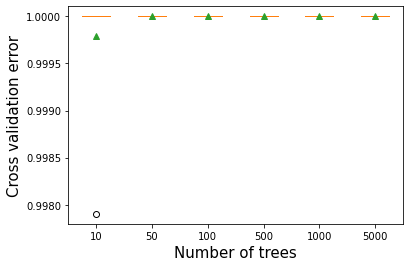

In [ ]:
def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [10, 50, 100, 500, 1000, 5000]
    for n in n_trees:
        models[str(n)] = AdaBoostClassifier(n_estimators=n,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

# Model Development: XGBoost

In [71]:
X_train.loc[:, plist]

,HETENURE,HEFAMINC,HWHHWGT,HRNUMHOU,HRHTYPE,HRMIS,HRHHID2,GEDIV,GESTFIPS,GTCBSA,...,GTCSA,PRTAGE,PEEDUCA,PWFMWGT,PWLGWGT,PWSSWGT,PWVETWGT,QSTNUM,PWCMPWGT,HXFAMINC
112251,3,13,34491316,3,4,5,12111,6,47,0,...,0,26,39,29445158,0,29445158,30622270,56171,30649540,42
89743,3,3,12853838,2,4,5,12012,8,35,22140,...,0,29,35,12853838,0,12853838,11304924,44370,11504978,0
114059,2,10,37756466,5,1,6,12011,3,17,44100,...,0,28,40,37756466,0,37756466,37957235,57193,37991036,23
33973,2,16,40579130,2,1,7,12011,3,18,26900,...,0,31,43,40579130,60302779,40579130,39956488,17188,40140673,0
20904,1,16,45467838,3,1,8,12011,5,24,12580,...,548,53,44,45467838,67567663,45467838,45859570,10727,45859610,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18379,3,13,21372705,4,1,2,13011,6,1,13820,...,0,10,-1,23960728,0,23960728,0,9349,0,0
94077,1,11,33387906,2,6,5,12012,9,6,31080,...,348,37,43,33387906,0,33387906,32546139,46475,33223156,0
8856,2,1,40151439,2,4,2,13011,6,47,34980,...,0,10,-1,49328281,0,49328281,0,4651,0,0
98134,1,15,28083647,2,1,5,12011,7,40,36420,...,0,48,42,28083647,0,22532325,22323298,48327,22715863,0


In [81]:
X_train_filtered = X_train.loc[:, plist]
X_test_filtered = X_test.loc[:, plist]

In [82]:
scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)
scale_pos_weight

4.790933009512244

In [83]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Optimal estimators search
param_grid = {'n_estimators': [100, 200, 1000, 4000], 
              'learning_rate': [0.01, 0.1, 0.5, 1.0], 
              'max_depth': range(2, 23, 2), 
              'subsample': [0.3, 0.5, 0.6], 
              'gamma': range(1, 10, 2), 
              'reg_lambda': [1, 5, 10], 
              'colsample_bytree': [0.25, 0.5, 0.75], 
              'scale_pos_weight': [scale_pos_weight]}

# Defining the evaluation procedure
cv = KFold(n_splits = 3, shuffle = True)

# Defining the grid search procedure
grid_search = RandomizedSearchCV(estimator = xgb.XGBClassifier(), param_distributions = param_grid, n_iter = 15, n_jobs = -1, cv = cv, 
                          verbose = True, scoring = 'accuracy')
# execute the grid search
grid_result = grid_search.fit(X_train_filtered, y_train)

# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best: 0.892636 using {'subsample': 0.5, 'scale_pos_weight': 4.790933009512244, 'reg_lambda': 1, 'n_estimators': 1000, 'max_depth': 16, 'learning_rate': 0.1, 'gamma': 7, 'colsample_bytree': 0.75}


In [145]:
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_scale_pos_weight,param_reg_lambda,param_n_estimators,param_max_depth,param_learning_rate,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,163.766595,0.164579,1.449526,0.007019,0.3,4.790933,10,1000,14,0.5,5,0.5,"{'subsample': 0.3, 'scale_pos_weight': 4.79093...",0.853586,0.857457,0.854679,0.855241,0.001630,11
1,711.109345,22.447739,10.677864,0.085250,0.3,4.790933,5,4000,20,0.01,5,0.5,"{'subsample': 0.3, 'scale_pos_weight': 4.79093...",0.871619,0.875649,0.873552,0.873606,0.001646,8
2,16.327615,0.263106,0.168473,0.007494,0.3,4.790933,1,200,6,1.0,3,0.75,"{'subsample': 0.3, 'scale_pos_weight': 4.79093...",0.748742,0.736094,0.739292,0.741376,0.005369,15
3,4.127841,0.088428,0.039264,0.001448,0.6,4.790933,1,100,2,0.5,3,0.75,"{'subsample': 0.6, 'scale_pos_weight': 4.79093...",0.776368,0.775780,0.774522,0.775557,0.000770,14
4,358.559594,20.877077,1.720550,0.050991,0.6,4.790933,1,4000,12,0.1,9,0.25,"{'subsample': 0.6, 'scale_pos_weight': 4.79093...",0.877595,0.882674,0.877326,0.879198,0.002460,4


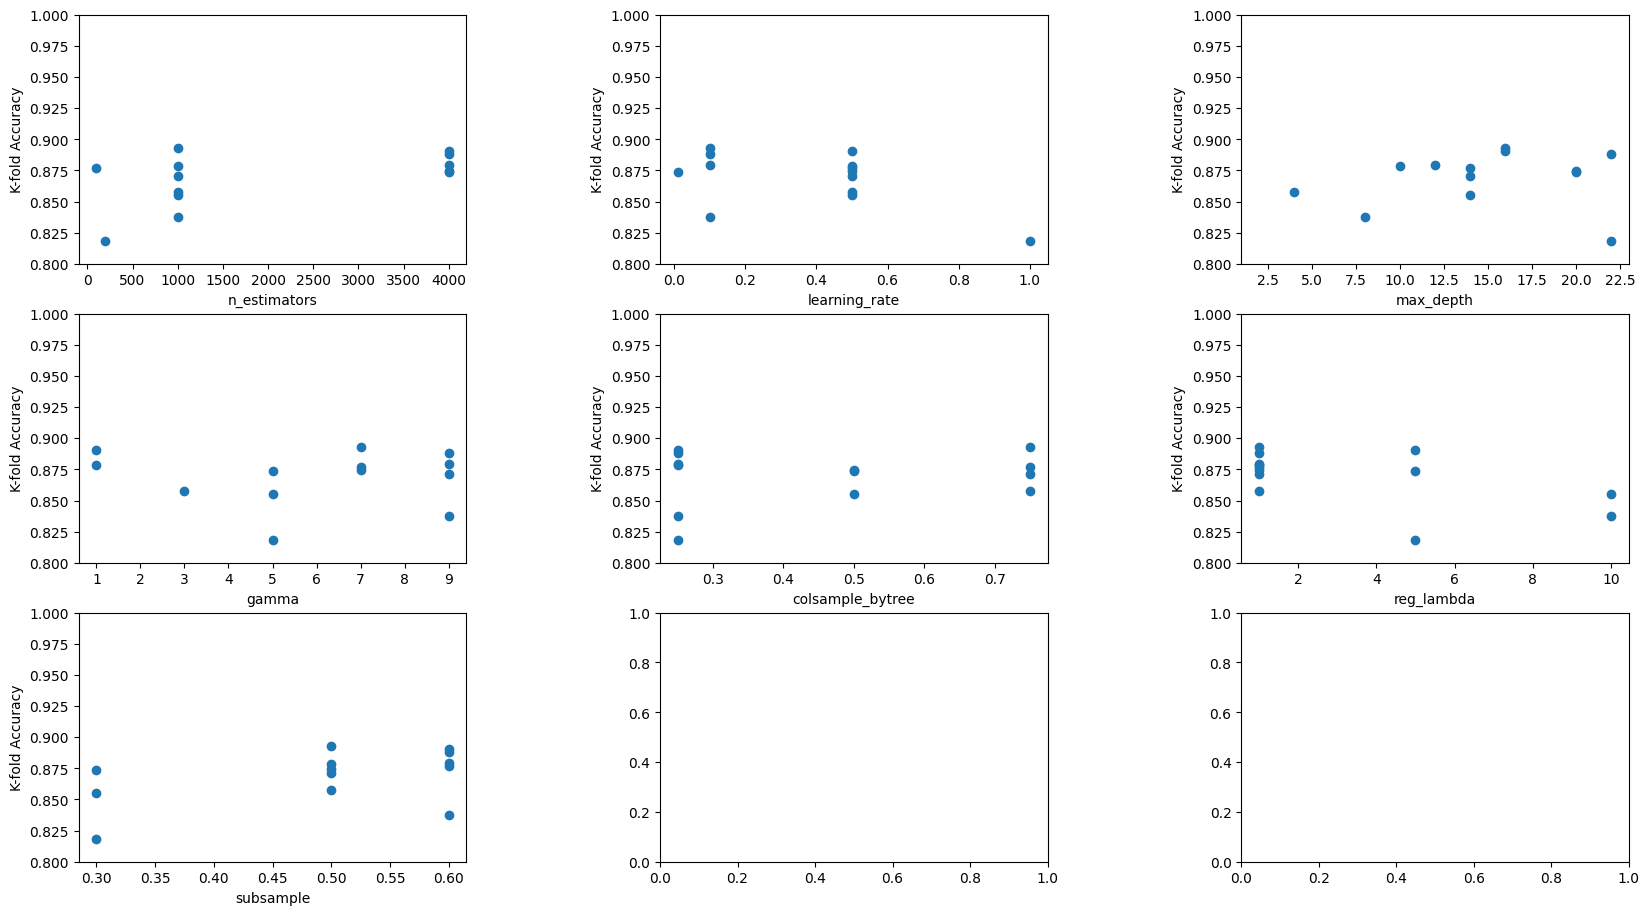

In [182]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.head();

fig, axes = plt.subplots(3, 3, figsize=(20,11))
plt.subplots_adjust(wspace = 0.5)
axes[0, 0].plot(cv_results.param_n_estimators, cv_results.mean_test_score, 'o')
axes[0, 0].set_ylim([0.8, 1])
axes[0, 0].set_xlabel('n_estimators')
axes[0, 0].set_ylabel('K-fold Accuracy')
axes[0, 1].plot(cv_results.param_learning_rate, cv_results.mean_test_score, 'o')
axes[0, 1].set_ylim([0.8, 1])
axes[0, 1].set_xlabel('learning_rate')
axes[0, 1].set_ylabel('K-fold Accuracy');
axes[0, 2].plot(cv_results.param_max_depth, cv_results.mean_test_score, 'o')
axes[0, 2].set_ylim([0.8, 1])
axes[0, 2].set_xlabel('max_depth')
axes[0, 2].set_ylabel('K-fold Accuracy');
axes[1, 0].plot(cv_results.param_gamma, cv_results.mean_test_score, 'o')
axes[1, 0].set_ylim([0.8, 1])
axes[1, 0].set_xlabel('gamma')
axes[1, 0].set_ylabel('K-fold Accuracy');
axes[1, 1].plot(cv_results.param_colsample_bytree, cv_results.mean_test_score, 'o')
axes[1, 1].set_ylim([0.8, 1])
axes[1, 1].set_xlabel('colsample_bytree')
axes[1, 1].set_ylabel('K-fold Accuracy');
axes[1, 2].plot(cv_results.param_reg_lambda, cv_results.mean_test_score, 'o')
axes[1, 2].set_ylim([0.8, 1])
axes[1, 2].set_xlabel('reg_lambda')
axes[1, 2].set_ylabel('K-fold Accuracy');
axes[2, 0].plot(cv_results.param_subsample, cv_results.mean_test_score, 'o')
axes[2, 0].set_ylim([0.8, 1])
axes[2, 0].set_xlabel('subsample')
axes[2, 0].set_ylabel('K-fold Accuracy');

In [87]:
baseline_model = xgb.XGBClassifier().fit(X_train_filtered, y_train)

In [84]:
# Fitting model with optimals from Randomized
model = xgb.XGBClassifier(max_depth = 16, subsample = 0.5, scale_pos_weight = scale_pos_weight, reg_lambda = 1, n_estimators = 1000, learning_rate = 0.1, gamma = 7, colsample_bytree = 0.75).fit(X_train_filtered, y_train)

Train Scores
Accuracy:  92.47894313773459
Recall:  66.535114349322
Precision:  86.83306920232435


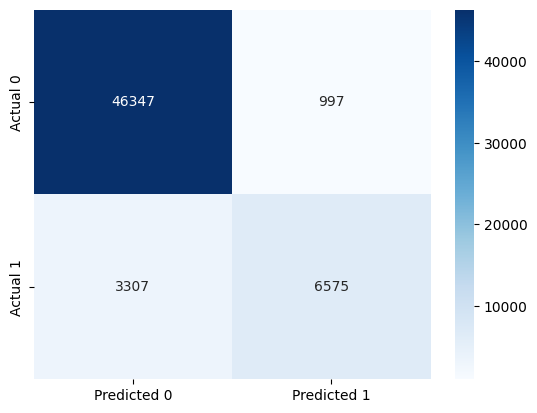

In [91]:
#Computing the accuracy and recall
print('Train Scores')
print("Accuracy: ",accuracy_score(y_train, baseline_model.predict(X_train_filtered))*100)  
print("Recall: ", recall_score(y_train, baseline_model.predict(X_train_filtered))*100)
print("Precision: ", precision_score(y_train, baseline_model.predict(X_train_filtered))*100)

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_train, baseline_model.predict(X_train_filtered)), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

Test Scores
Accuracy:  88.37631928426644
Recall:  51.602690937870996
Precision:  74.77064220183486


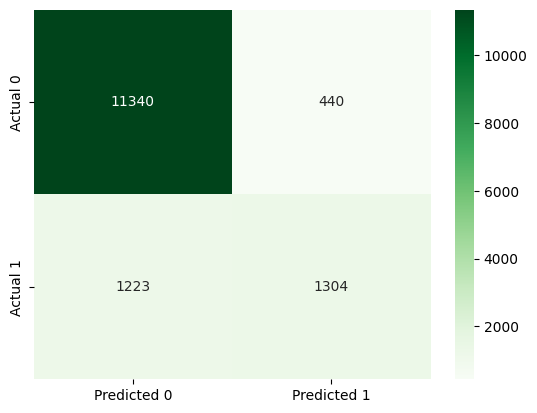

In [213]:
#Computing the accuracy and recall
print('Test Scores')
print("Accuracy: ", accuracy_score(y_test, baseline_model.predict(X_test_filtered))*100)  
print("Recall: ", recall_score(y_test, baseline_model.predict(X_test_filtered))*100)
print("Precision: ", precision_score(y_test, baseline_model.predict(X_test_filtered))*100)

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, baseline_model.predict(X_test_filtered)), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g');

Train Scores
Accuracy:  98.6789221682452
Recall:  99.96964177292045
Precision:  92.9176072234763


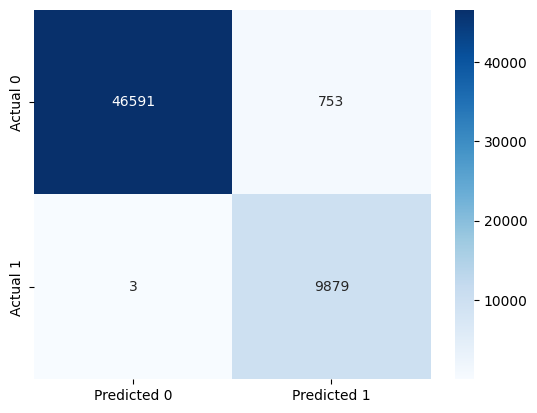

In [93]:
# Performance metrics computation for the optimum decision threshold probability
#desired_threshold = 0.447

#y_pred_prob = model.predict_proba(X_train)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
#y_pred = y_pred_prob > desired_threshold
#y_pred = y_pred.astype(int)

#Computing the accuracy and recall
print('Train Scores')
print("Accuracy: ",accuracy_score(y_train, model.predict(X_train_filtered))*100)  
print("Recall: ", recall_score(y_train, model.predict(X_train_filtered))*100)
print("Precision: ", precision_score(y_train, model.predict(X_train_filtered))*100)

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_train, model.predict(X_train_filtered)), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

Test Scores
Accuracy:  91.87810162857343
Recall:  82.11317768104472
Precision:  74.50628366247756


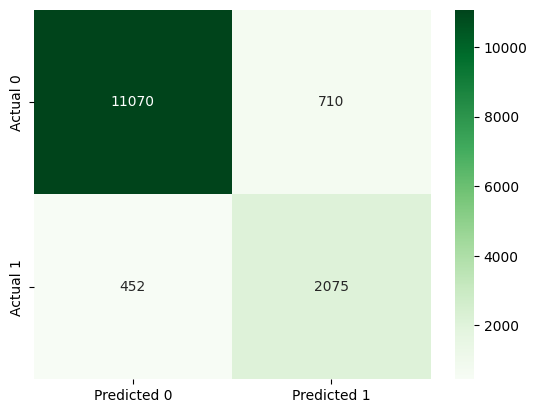

In [212]:
#Computing the accuracy and recall
print('Test Scores')
print("Accuracy: ", accuracy_score(y_test, model.predict(X_test_filtered))*100)  
print("Recall: ", recall_score(y_test, model.predict(X_test_filtered))*100)
print("Precision: ", precision_score(y_test, model.predict(X_test_filtered))*100)

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, model.predict(X_test_filtered)), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g');

In [192]:
# Optimal estimators search
param_grid = {'n_estimators': [1000, 1500, 2000], 
              'learning_rate': [0.01, 0.1], 
              'max_depth': range(15, 18), 
              'subsample': [0.5, 0.55], 
              'gamma': [6, 7, 8], 
              'reg_lambda': [1, 1.5, 2], 
              'colsample_bytree': [0.5, 0.75], 
              'scale_pos_weight': [scale_pos_weight]}

# Defining the evaluation procedure
cv = StratifiedKFold(n_splits = 5, shuffle = True)

# Defining the grid search procedure
grid_search = RandomizedSearchCV(estimator = xgb.XGBClassifier(), param_distributions = param_grid, n_iter=20, n_jobs = -1, cv = cv, 
                          verbose = True, scoring = ['accuracy', 'recall'], refit = 'accuracy')
# execute the grid search
grid_result = grid_search.fit(X_train_filtered, y_train)

# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best: 0.908398 using {'subsample': 0.55, 'scale_pos_weight': 4.790933009512244, 'reg_lambda': 2, 'n_estimators': 1500, 'max_depth': 17, 'learning_rate': 0.1, 'gamma': 6, 'colsample_bytree': 0.75}


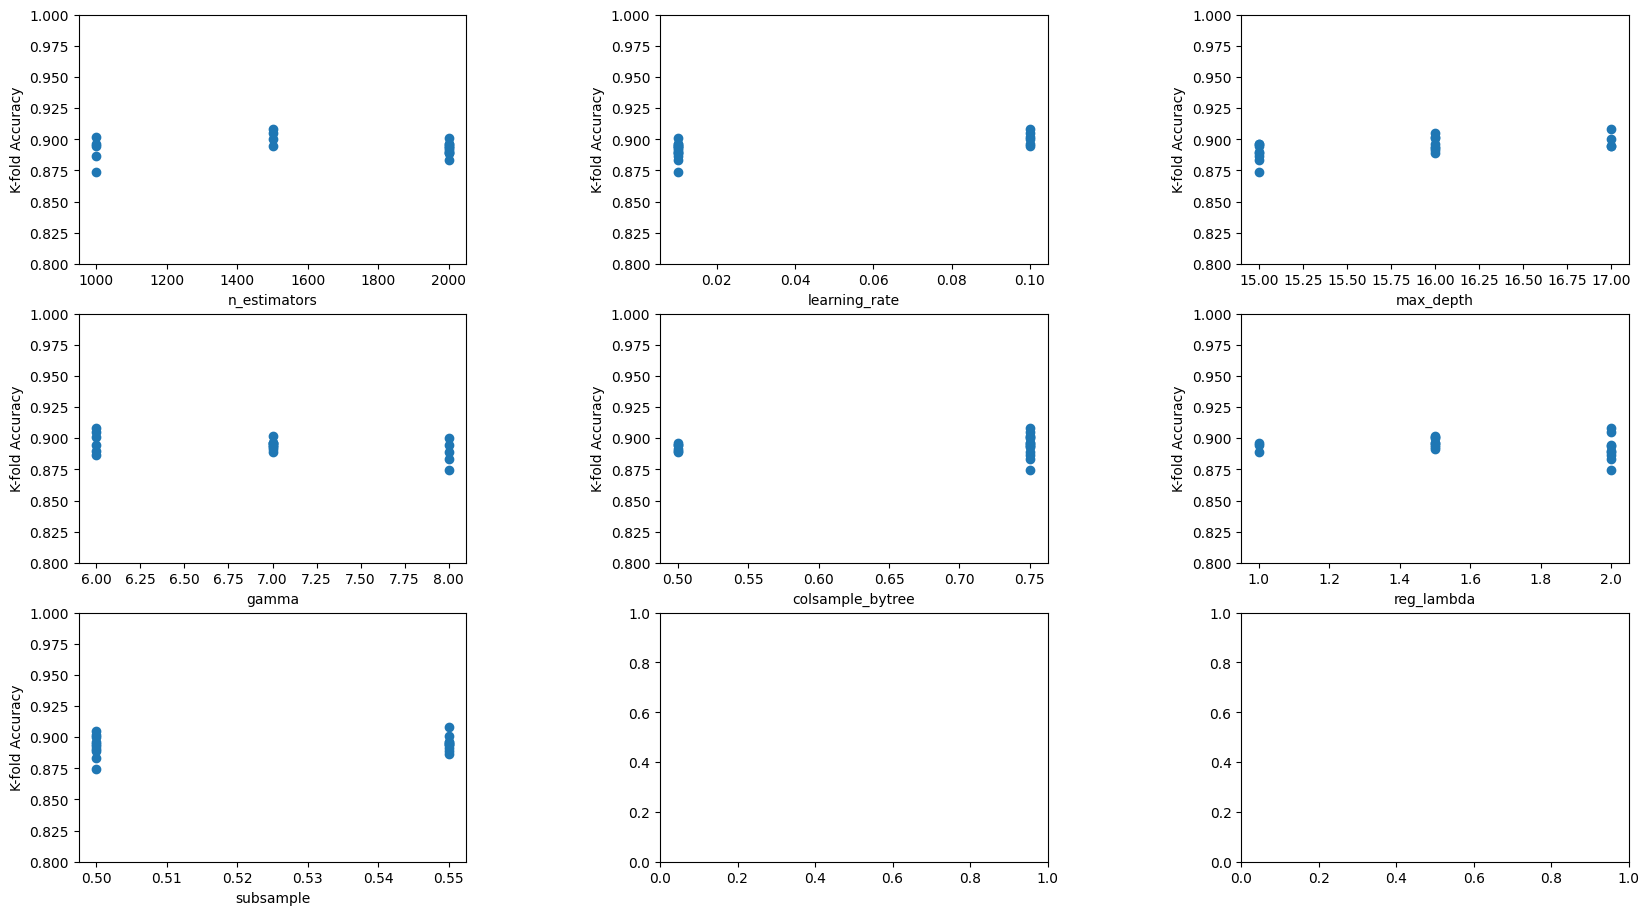

In [195]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.head();

fig, axes = plt.subplots(3, 3, figsize=(20,11))
plt.subplots_adjust(wspace = 0.5)
axes[0, 0].plot(cv_results.param_n_estimators, cv_results.mean_test_accuracy, 'o')
axes[0, 0].set_ylim([0.8, 1])
axes[0, 0].set_xlabel('n_estimators')
axes[0, 0].set_ylabel('K-fold Accuracy')
axes[0, 1].plot(cv_results.param_learning_rate, cv_results.mean_test_accuracy, 'o')
axes[0, 1].set_ylim([0.8, 1])
axes[0, 1].set_xlabel('learning_rate')
axes[0, 1].set_ylabel('K-fold Accuracy');
axes[0, 2].plot(cv_results.param_max_depth, cv_results.mean_test_accuracy, 'o')
axes[0, 2].set_ylim([0.8, 1])
axes[0, 2].set_xlabel('max_depth')
axes[0, 2].set_ylabel('K-fold Accuracy');
axes[1, 0].plot(cv_results.param_gamma, cv_results.mean_test_accuracy, 'o')
axes[1, 0].set_ylim([0.8, 1])
axes[1, 0].set_xlabel('gamma')
axes[1, 0].set_ylabel('K-fold Accuracy');
axes[1, 1].plot(cv_results.param_colsample_bytree, cv_results.mean_test_accuracy, 'o')
axes[1, 1].set_ylim([0.8, 1])
axes[1, 1].set_xlabel('colsample_bytree')
axes[1, 1].set_ylabel('K-fold Accuracy');
axes[1, 2].plot(cv_results.param_reg_lambda, cv_results.mean_test_accuracy, 'o')
axes[1, 2].set_ylim([0.8, 1])
axes[1, 2].set_xlabel('reg_lambda')
axes[1, 2].set_ylabel('K-fold Accuracy');
axes[2, 0].plot(cv_results.param_subsample, cv_results.mean_test_accuracy, 'o')
axes[2, 0].set_ylim([0.8, 1])
axes[2, 0].set_xlabel('subsample')
axes[2, 0].set_ylabel('K-fold Accuracy');

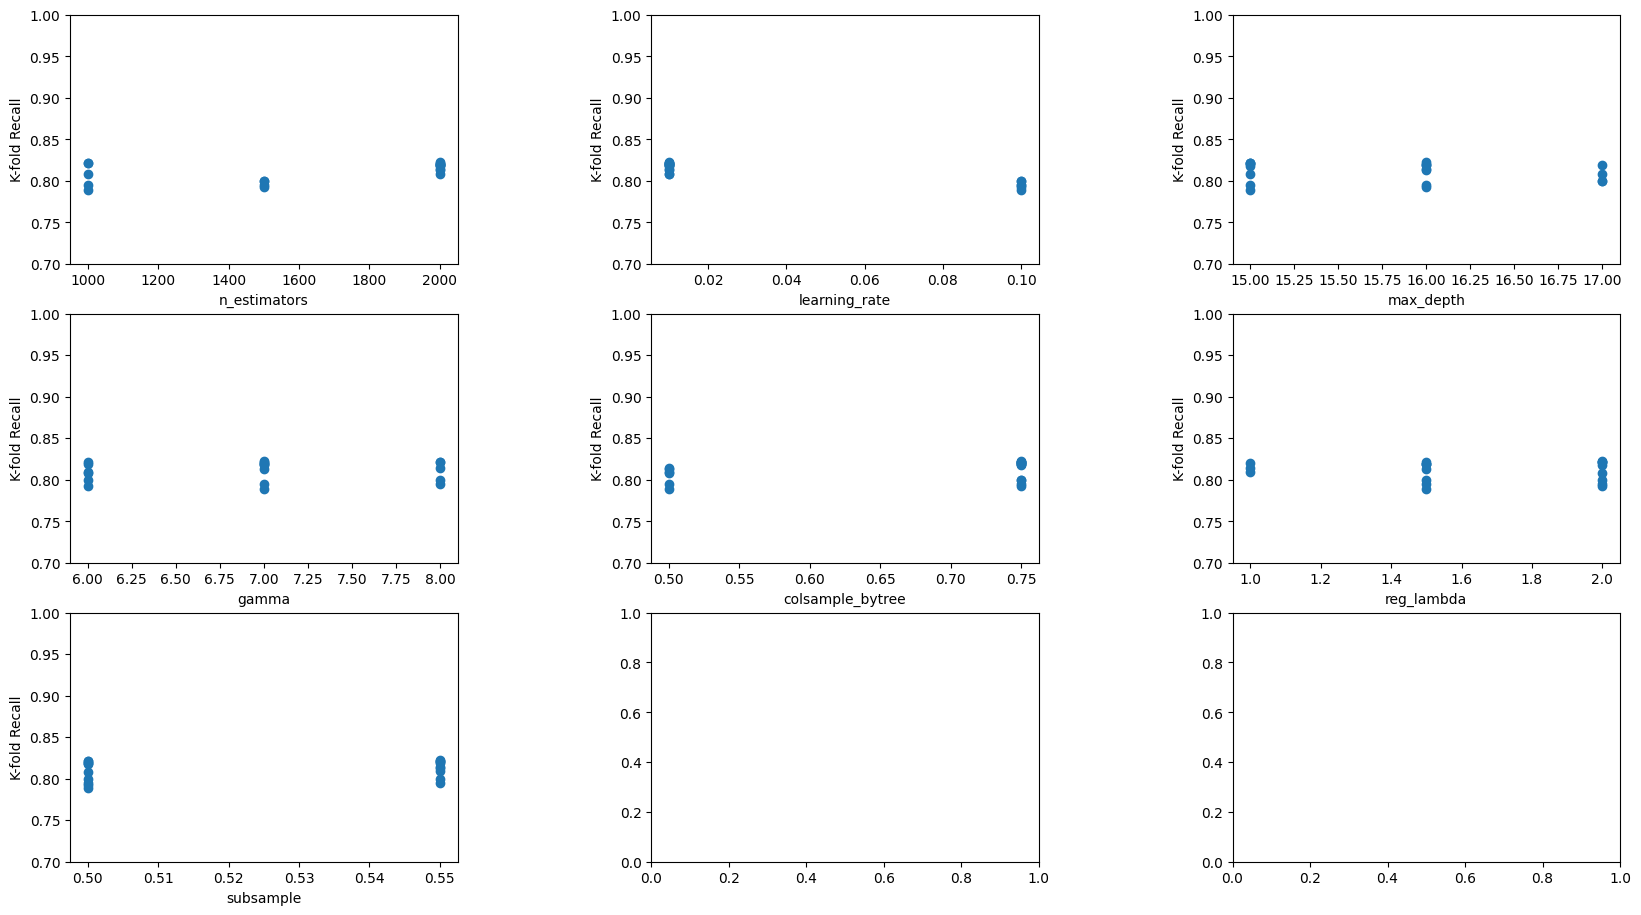

In [197]:
fig, axes = plt.subplots(3, 3, figsize=(20,11))
plt.subplots_adjust(wspace = 0.5)
axes[0, 0].plot(cv_results.param_n_estimators, cv_results.mean_test_recall, 'o')
axes[0, 0].set_ylim([0.7, 1])
axes[0, 0].set_xlabel('n_estimators')
axes[0, 0].set_ylabel('K-fold Recall')
axes[0, 1].plot(cv_results.param_learning_rate, cv_results.mean_test_recall, 'o')
axes[0, 1].set_ylim([0.7, 1])
axes[0, 1].set_xlabel('learning_rate')
axes[0, 1].set_ylabel('K-fold Recall');
axes[0, 2].plot(cv_results.param_max_depth, cv_results.mean_test_recall, 'o')
axes[0, 2].set_ylim([0.7, 1])
axes[0, 2].set_xlabel('max_depth')
axes[0, 2].set_ylabel('K-fold Recall');
axes[1, 0].plot(cv_results.param_gamma, cv_results.mean_test_recall, 'o')
axes[1, 0].set_ylim([0.7, 1])
axes[1, 0].set_xlabel('gamma')
axes[1, 0].set_ylabel('K-fold Recall');
axes[1, 1].plot(cv_results.param_colsample_bytree, cv_results.mean_test_recall, 'o')
axes[1, 1].set_ylim([0.7, 1])
axes[1, 1].set_xlabel('colsample_bytree')
axes[1, 1].set_ylabel('K-fold Recall');
axes[1, 2].plot(cv_results.param_reg_lambda, cv_results.mean_test_recall, 'o')
axes[1, 2].set_ylim([0.7, 1])
axes[1, 2].set_xlabel('reg_lambda')
axes[1, 2].set_ylabel('K-fold Recall');
axes[2, 0].plot(cv_results.param_subsample, cv_results.mean_test_recall, 'o')
axes[2, 0].set_ylim([0.7, 1])
axes[2, 0].set_xlabel('subsample')
axes[2, 0].set_ylabel('K-fold Recall');

In [198]:
# Fitting model with optimals from Randomized
model2 = xgb.XGBClassifier(max_depth = 17, subsample = 0.55, scale_pos_weight = scale_pos_weight, reg_lambda = 2, n_estimators = 1500, learning_rate = 0.1, gamma = 6, colsample_bytree = 0.75).fit(X_train_filtered, y_train)

Test Scores
Accuracy:  92.32543510169847
Recall:  82.50890383854372
Precision:  76.06712878511492


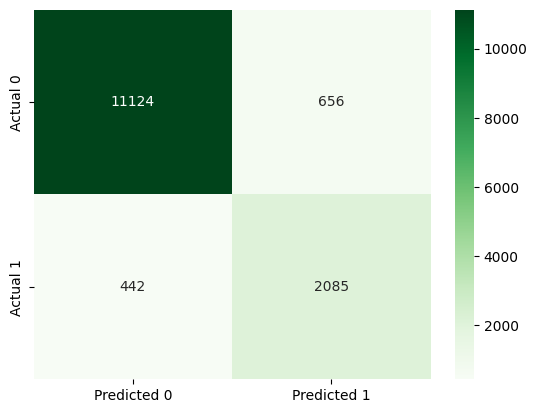

In [211]:
#Computing the accuracy and recall
print('Test Scores')
print("Accuracy: ", accuracy_score(y_test, model2.predict(X_test_filtered))*100)  
print("Recall: ", recall_score(y_test, model2.predict(X_test_filtered))*100)
print("Precision: ", precision_score(y_test, model2.predict(X_test_filtered))*100)

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, model2.predict(X_test_filtered)), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g');

In [201]:
# Trial and Error based on Graphs
# Fitting model with optimals from Randomized
model3 = xgb.XGBClassifier(max_depth = 17, subsample = 0.55, scale_pos_weight = scale_pos_weight, reg_lambda = 2, n_estimators = 2000, learning_rate = 0.01, gamma = 6, colsample_bytree = 0.75).fit(X_train_filtered, y_train)

Test Scores
Accuracy:  91.56357028028238
Recall:  83.77522754254056
Precision:  72.64927934111188


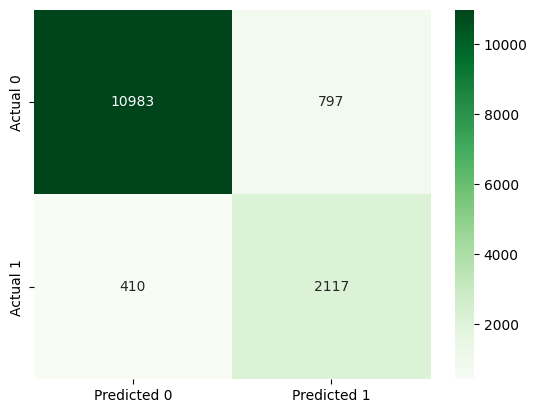

In [210]:
#Computing the accuracy and recall
print('Test Scores')
print("Accuracy: ", accuracy_score(y_test, model3.predict(X_test_filtered))*100)  
print("Recall: ", recall_score(y_test, model3.predict(X_test_filtered))*100)
print("Precision: ", precision_score(y_test, model3.predict(X_test_filtered))*100)

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, model3.predict(X_test_filtered)), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g');

In [204]:
# Optimal estimators search for refitting on recall
param_grid = {'n_estimators': [1500, 2000, 3000, 3500], 
              'learning_rate': [0.001, 0.01, 0.1], 
              'max_depth': range(16, 19), 
              'subsample': [0.53, 0.55, 0.56], 
              'gamma': [6, 7, 8], 
              'reg_lambda': [1.5, 2, 3], 
              'colsample_bytree': [0.5, 0.75, 0.9], 
              'scale_pos_weight': [scale_pos_weight]}

# Defining the evaluation procedure
cv = StratifiedKFold(n_splits = 5, shuffle = True)

# Defining the grid search procedure
grid_search = RandomizedSearchCV(estimator = xgb.XGBClassifier(), param_distributions = param_grid, n_iter=25, n_jobs = -1, cv = cv, 
                          verbose = True, scoring = ['accuracy', 'recall'], refit = 'recall')
# execute the grid search
grid_result = grid_search.fit(X_train_filtered, y_train)

# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best: 0.828578 using {'subsample': 0.55, 'scale_pos_weight': 4.790933009512244, 'reg_lambda': 3, 'n_estimators': 2000, 'max_depth': 18, 'learning_rate': 0.01, 'gamma': 8, 'colsample_bytree': 0.9}


Text(0.5, 0, 'subsample')

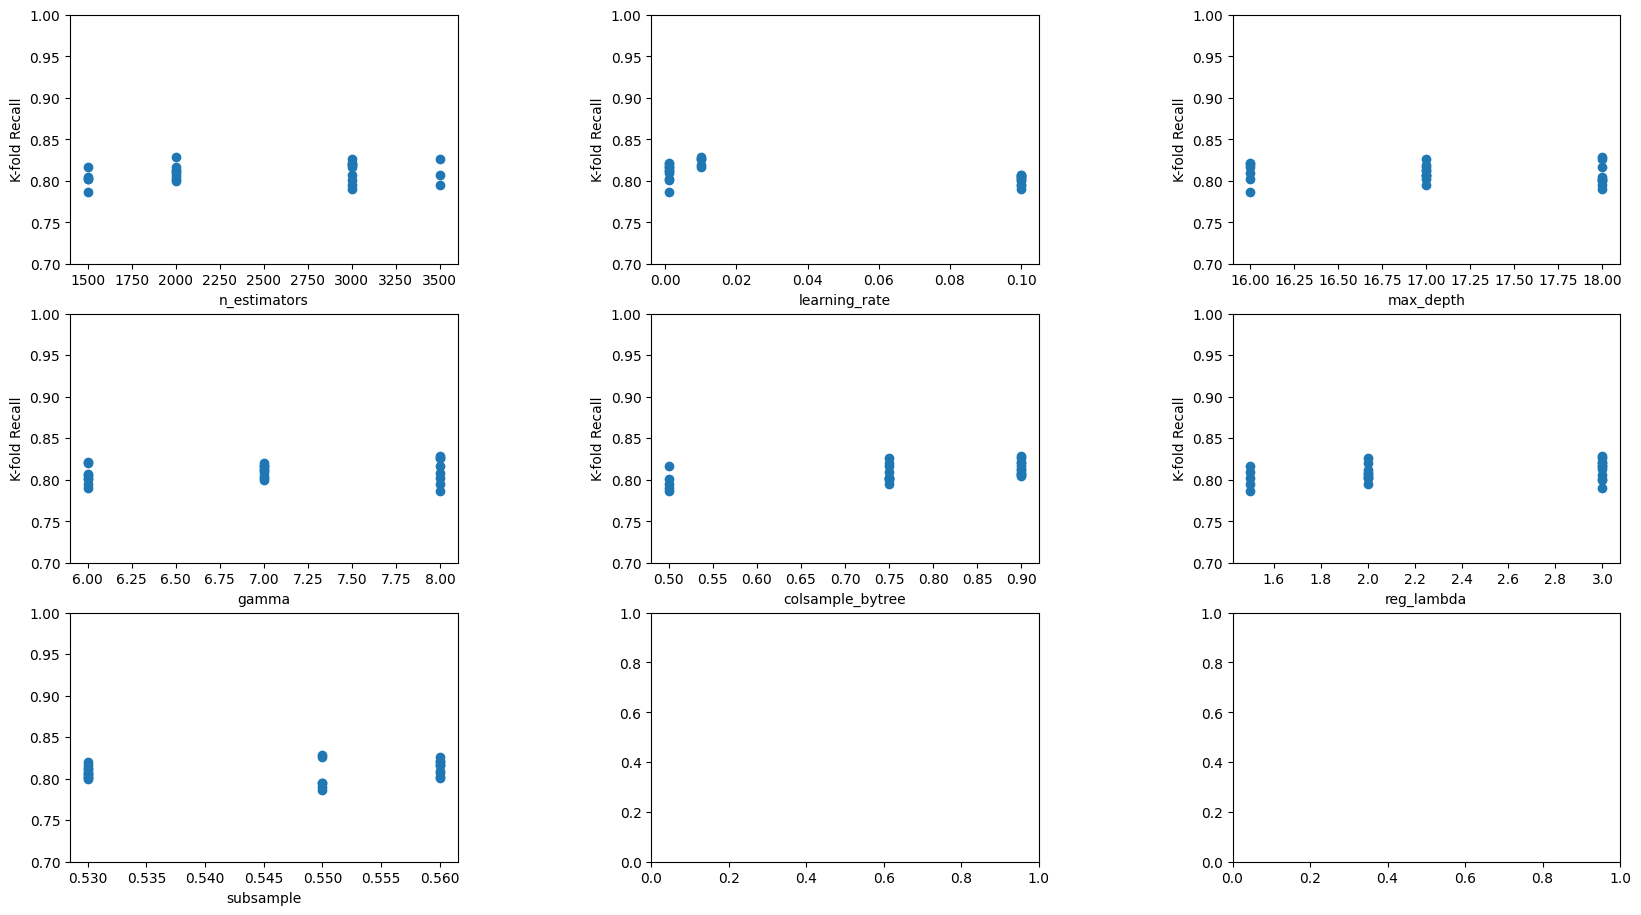

In [206]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.head();

fig, axes = plt.subplots(3, 3, figsize=(20,11))
plt.subplots_adjust(wspace = 0.5)
axes[0, 0].plot(cv_results.param_n_estimators, cv_results.mean_test_recall, 'o')
axes[0, 0].set_ylim([0.7, 1])
axes[0, 0].set_xlabel('n_estimators')
axes[0, 0].set_ylabel('K-fold Recall')
axes[0, 1].plot(cv_results.param_learning_rate, cv_results.mean_test_recall, 'o')
axes[0, 1].set_ylim([0.7, 1])
axes[0, 1].set_xlabel('learning_rate')
axes[0, 1].set_ylabel('K-fold Recall');
axes[0, 2].plot(cv_results.param_max_depth, cv_results.mean_test_recall, 'o')
axes[0, 2].set_ylim([0.7, 1])
axes[0, 2].set_xlabel('max_depth')
axes[0, 2].set_ylabel('K-fold Recall');
axes[1, 0].plot(cv_results.param_gamma, cv_results.mean_test_recall, 'o')
axes[1, 0].set_ylim([0.7, 1])
axes[1, 0].set_xlabel('gamma')
axes[1, 0].set_ylabel('K-fold Recall');
axes[1, 1].plot(cv_results.param_colsample_bytree, cv_results.mean_test_recall, 'o')
axes[1, 1].set_ylim([0.7, 1])
axes[1, 1].set_xlabel('colsample_bytree')
axes[1, 1].set_ylabel('K-fold Recall');
axes[1, 2].plot(cv_results.param_reg_lambda, cv_results.mean_test_recall, 'o')
axes[1, 2].set_ylim([0.7, 1])
axes[1, 2].set_xlabel('reg_lambda')
axes[1, 2].set_ylabel('K-fold Recall');
axes[2, 0].plot(cv_results.param_subsample, cv_results.mean_test_recall, 'o')
axes[2, 0].set_ylim([0.7, 1])
axes[2, 0].set_xlabel('subsample')

In [207]:
# Fitting model with optimals from Randomized for Recall
model4 = xgb.XGBClassifier(max_depth = 18, subsample = 0.55, scale_pos_weight = scale_pos_weight, reg_lambda = 3, n_estimators = 2000, learning_rate = 0.01, gamma = 8, colsample_bytree = 0.9).fit(X_train_filtered, y_train)

Test Scores
Accuracy:  90.4662053540225
Recall:  84.72497032053819
Precision:  68.6437960884899


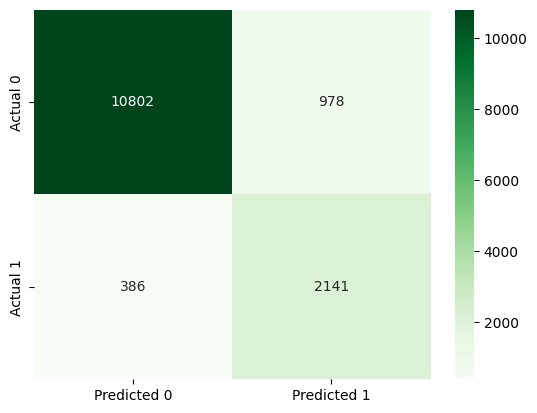

In [208]:
#Computing the accuracy and recall
print('Test Scores')
print("Accuracy: ", accuracy_score(y_test, model4.predict(X_test_filtered))*100)  
print("Recall: ", recall_score(y_test, model4.predict(X_test_filtered))*100)
print("Precision: ", precision_score(y_test, model4.predict(X_test_filtered))*100)

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, model4.predict(X_test_filtered)), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g');

In [216]:
# Fitting model with all pred
modelall = xgb.XGBClassifier().fit(X_train, y_train)

Test Scores
Accuracy:  88.59299643531139
Recall:  52.98773248911753
Precision:  75.09814918676389


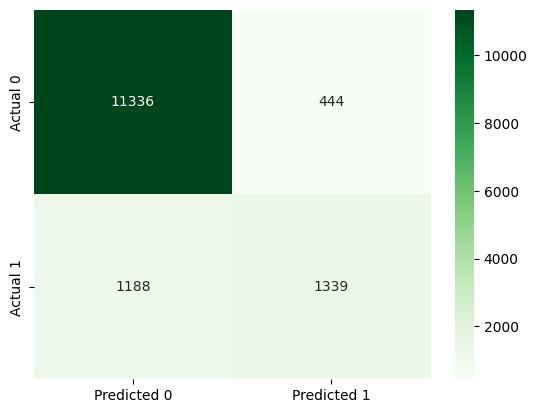

In [218]:
#Computing the accuracy and recall
print('Test Scores')
print("Accuracy: ", accuracy_score(y_test, modelall.predict(X_test))*100)  
print("Recall: ", recall_score(y_test, modelall.predict(X_test))*100)
print("Precision: ", precision_score(y_test, modelall.predict(X_test))*100)

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, modelall.predict(X_test)), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g');

In [219]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

# KFold probabilities
cross_val_prob = cross_val_predict(model2, X_train_filtered, y_train, method = 'predict_proba', n_jobs = -1, cv = 5)

# Getting p, r, thresholds, (by function) and accuracies (by for loop) 
p, r, thresholds = precision_recall_curve(y_train, cross_val_prob[:,1])

accuracies = []

for threshold in thresholds:
    predicted_class = cross_val_prob[:,1] > threshold
    predicted_class = predicted_class.astype(int)
    
    #Computing optimals
    accuracies = accuracies + [accuracy_score(y_train, predicted_class)]

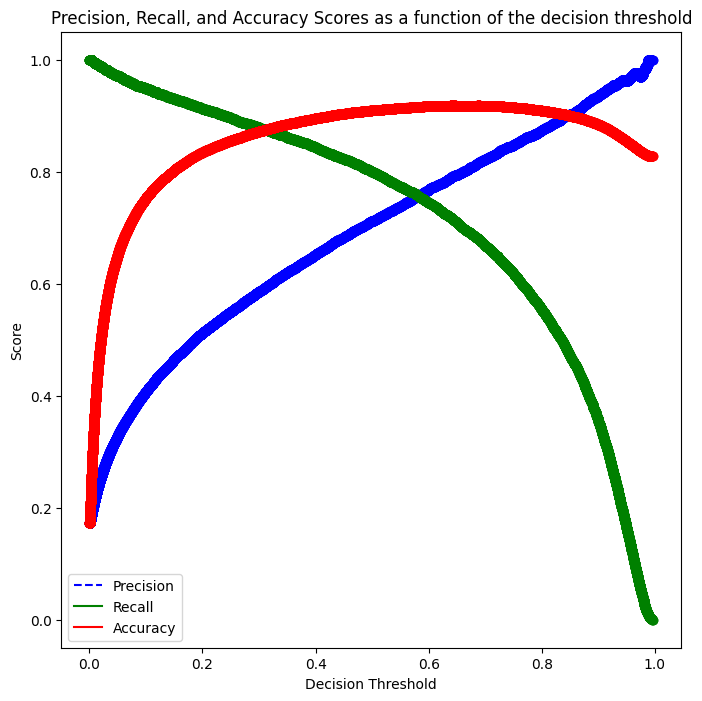

In [220]:
# Plotting function
def plot_precision_recall_vs_threshold(precisions, recalls, accuracies, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision, Recall, and Accuracy Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, accuracies, "r-", label="Accuracy")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.plot(thresholds, accuracies, "o", color = 'red')
    plt.plot
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, accuracies, thresholds)

In [221]:
# Testing thresholds
metrics_iter = pd.DataFrame(columns = ['threshold', 'recall', 'accuracy'])
threshold_hyperparam_vals = np.arange(0.3, 0.5, 0.001)
iter_number = 0

for threshold_prob in threshold_hyperparam_vals:
    predicted_class = cross_val_prob[:,1] > threshold_prob
    predicted_class = predicted_class.astype(int)
    
    #Computing optimals
    accuracy = accuracy_score(y_train, predicted_class)
    recall = recall_score(y_train, predicted_class)
    metrics_iter.loc[iter_number, 'threshold'] = threshold_prob
    metrics_iter.loc[iter_number, 'recall'] = recall
    metrics_iter.loc[iter_number, 'accuracy'] = accuracy
    iter_number = iter_number + 1

In [227]:
new = metrics_iter[metrics_iter.accuracy >= 0.90]
new[new.recall >= 0.83]

,threshold,recall,accuracy
128,0.428,0.831411,0.900203
129,0.429,0.830905,0.900325
130,0.43,0.830905,0.900692
131,0.431,0.830095,0.900779


Test Scores
Accuracy:  91.54959110924722
Recall:  85.1602690937871
Precision:  72.06965840589417


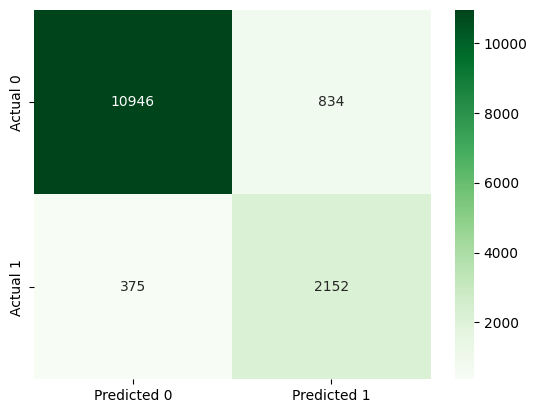

In [234]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.431

y_pred_prob = model2.predict_proba(X_test_filtered)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy and recall
print('Test Scores')
print("Accuracy: ", accuracy_score(y_test, y_pred)*100)  
print("Recall: ", recall_score(y_test, y_pred)*100)
print("Precision: ", precision_score(y_test, y_pred)*100)

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g');

# Outlier Detection

In [239]:
# identify outliers in the training dataset
from sklearn.ensemble import IsolationForest
iso = IsolationForest(n_jobs = -1)
yhat = iso.fit_predict(X_train_filtered)

In [240]:
mask = yhat != -1
X_train_noout, y_train_noout = X_train_filtered.loc[mask, :], y_train[mask]

In [241]:
X_train_filtered.shape

(57226, 22)

In [243]:
X_train_noout.shape # Using default

(37670, 22)

In [245]:
len(y_train_noout)

37670

In [246]:
X_train_noout.to_csv('X_train_tree_noout.csv')
y_train_noout.to_csv('y_train_tree_noout.csv')

# CatBoost Attempt

In [97]:
%%capture
pip install catboost

In [99]:
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, CatBoostClassifier

In [100]:
cbmodel = CatBoostClassifier(verbose = False).fit(X_train_filtered, y_train)

Train Scores
Accuracy:  91.80092964736308
Recall:  61.51588747217163
Precision:  87.24167623421354


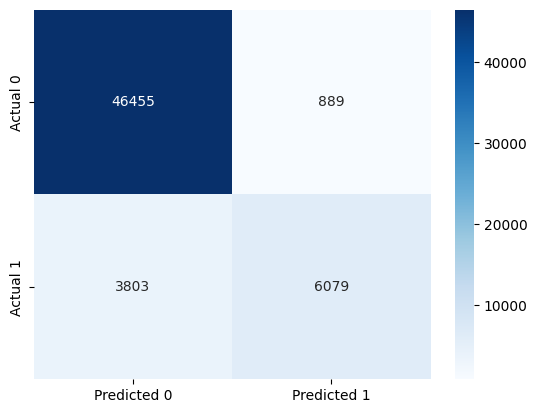

In [101]:
print('Train Scores')
print("Accuracy: ",accuracy_score(y_train, cbmodel.predict(X_train_filtered))*100)  
print("Recall: ", recall_score(y_train, cbmodel.predict(X_train_filtered))*100)
print("Precision: ", precision_score(y_train, cbmodel.predict(X_train_filtered))*100)

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_train, cbmodel.predict(X_train_filtered)), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

Test Scores
Accuracy:  89.26399664499895
Recall:  52.07756232686981
Precision:  80.19500304692261


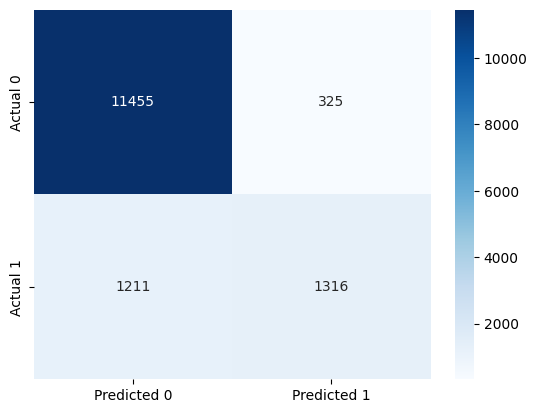

In [102]:
#Computing the accuracy and recall
print('Test Scores')
print("Accuracy: ", accuracy_score(y_test, cbmodel.predict(X_test_filtered))*100)  
print("Recall: ", recall_score(y_test, cbmodel.predict(X_test_filtered))*100)
print("Precision: ", precision_score(y_test, cbmodel.predict(X_test_filtered))*100)

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, cbmodel.predict(X_test_filtered)), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

In [103]:
X_train_filtered.to_csv('X_train_tree.csv')
y_train.to_csv('y_train_tree.csv')
X_test_filtered.to_csv('X_test_tree.csv')
y_test.to_csv('y_test_tree.csv')

In [168]:
y_test

87818     0
39776     0
42528     0
11877     0
63699     0
         ..
106307    1
89172     0
72690     0
40680     0
34673     0
Name: y, Length: 14307, dtype: int64